# Data Exploration Project - Pumps

## Business Understanding

Daten über verschiedene Brunnen in einem afrikanischen Land.

**Können wir vorhersagen welche Brunnen defekt, wartungsbedürftig oder voll funktional sind?**

## Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

Einlesen der Trainings- und Testdaten.

In [2]:
df_pump_train = pd.read_csv('pump_train.csv')
df_pump_test = pd.read_csv('pump_test.csv')

### Data Dictionary
| Variable | Beschreibung |
| -------- | ------------ |
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | ? |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data 
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed 
| extraction_type | The kind of extraction the waterpoint uses 
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses 
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | functional or non-functional or functional needs repair |

### Data Analysis

## Data Preparation

## Pipeline

[Categoric Encoder Package ->](https://contrib.scikit-learn.org/category_encoders/index.html)

In [3]:
class YesNoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, add_column = True):
        self.add_column = add_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_column:
            has_name = np.where(X['wpt_name']!= 'none', 1, 0)
            Xcopy = X
            Xcopy['wpt_name'] = has_name
        return Xcopy

In [4]:
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value="other"):
        self.fill_value = fill_value
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self.fill_value if str(x)==str(np.nan) else x for x in X]).reshape(-1,1)

In [5]:
scheme_pipeline = Pipeline([
('imputer', MyImputer(fill_value="other")),
('one_hot', OneHotEncoder())
])

In [6]:
class YearAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)
        

In [7]:
# from sklearn.ensemble import RandomForestRegressor

# class AgeOfPumpAdder(BaseEstimator, TransformerMixin):
#     def __init__(self, df_in, col_trans):
#         df_train = df_in.loc[(df_in["construction_year"].notnull())]
#         self.X_train = col_trans.fit_transform(X=df_train.drop("construction_year", axis=1), y=df_train["construction_year"])
#         self.rf = RandomForestClassifier(random_state=42)

#     def fit(self, X, y=None):
#         self.rf.fit(self.X_train, X)     
#         return self
    
#     def transform(self, X, y=None):
#         constr_year = self.rf.predict(X)

In [8]:
year_pipeline = Pipeline([
    ("add_year", YearAdder()),
    # ("ord_enc", OrdinalEncoder()),
    ("scale", MinMaxScaler())
])

In [9]:
age_pipeline = Pipeline([
    ("imp_age", SimpleImputer(strategy="median")),
    ("scale", MinMaxScaler())
])

In [10]:
class AmountPerCapitaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)

In [11]:
df_train = df_pump_train.copy()

# add new target variables

df_train["t_functional"] = df_train["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_train["t_needs_rep"] = df_train["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

# drop outliers
df_train = df_train.drop(df_train[df_train.longitude == 0].index)

# add some new features manually
df_train["amount_per_capita"] = df_train.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)
import datetime
df_train["age"]=df_train['date_recorded'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))-df_train["construction_year"].apply(lambda x: datetime.datetime.strptime(str(x),'%Y') if x!=0 else datetime.datetime.now())
df_train["age"].loc[df_train["construction_year"]!=0]=df_train["age"].loc[df_train["construction_year"]!=0].apply(lambda x: x.days)
df_train["age"].loc[df_train["construction_year"]==0]=np.nan

# transform dtypes manually
df_train["district_code"] = df_train["district_code"].astype("category")
df_train["region_code"] = df_train["region_code"].astype("category")

y_train = df_train.loc[:,'status_group']
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train_f = df_train["t_functional"]
y_train_r = df_train["t_needs_rep"]

col_imp = Pipeline([
    ('simp_inputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

target_enc_pipe = Pipeline([
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

scheme_pipeline_lbl = Pipeline([
    ('imputer', MyImputer(fill_value="other")),
    ('ord_enc', OrdinalEncoder()),
    ('min_max', MinMaxScaler())
])

ord_enc_pipe = Pipeline([
    ('ord_enc', OrdinalEncoder()),
    ('min_max', MinMaxScaler())
])

col_trans = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

col_trans_w_age = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"],
    ["age", age_pipeline, ["age"]]
], remainder='drop')

col_trans_lbl = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['ord_enc', ord_enc_pipe, ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class', 'region', 'region_code', 'district_code']],
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline_lbl, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')


col_trans_lbl_w_age = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['ord_enc', ord_enc_pipe, ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class', 'region', 'region_code', 'district_code']],
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline_lbl, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"],
    ["age", age_pipeline, ["age"]]
], remainder='drop')


col_trans_lbl_reduced = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward']],
    ['ord_enc', ord_enc_pipe, ['payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class', 'region', 'region_code']],
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh"]],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [12]:
X_train = col_trans.fit_transform(X=df_train, y=y_train)

C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


## Modeling

ToDo: Test with different Preparation-Pipelines

### a. Model Selection

In [13]:
df_results = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV"])

#### LogisticRegression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

lr_cf = LogisticRegression(multi_class="ovr", max_iter=1000)
lr_cf.fit(X_train, y_train)
y_pred = lr_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=lr_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

In [15]:
df_results.loc[len(df_results)] = [lr_cf, auc_train, auc_cv]

#### SVM

In [16]:
# from sklearn.svm import SVC

# svm_cf = SVC(probability=True, decision_function_shape="ovr")
# svm_cf.fit(X_train, y_train)
# y_pred = svm_cf.predict_proba(X_train)
# auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
# cv_res = cross_validate(estimator=svm_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
# auc_cv = cv_res["test_score"].mean()
# df_results.loc[len(df_results)] = [svm_cf, auc_train, auc_cv]

#### KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn_cf = KNeighborsClassifier()
knn_cf.fit(X_train, y_train)
y_pred = knn_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=knn_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [knn_cf, auc_train, auc_cv]

#### Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier

dt_cf = DecisionTreeClassifier()
dt_cf.fit(X_train, y_train)
y_pred = dt_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=dt_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [dt_cf, auc_train, auc_cv]

#### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train, y_train)
y_pred = rf_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [str(rf_cf), auc_train, auc_cv]

#### XGBoost

In [20]:
from xgboost import XGBClassifier

xgb_cf = XGBClassifier()
xgb_cf.fit(X_train, y_train)
y_pred = xgb_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [xgb_cf, auc_train, auc_cv]

In [21]:
# df_results.to_csv("pm3_sel_results.csv")
df_results

,Model,AUC Train,AUC CV
0,"LogisticRegression(max_iter=1000, multi_class=...",0.869001,0.866267
1,KNeighborsClassifier(),0.957829,0.855479
2,DecisionTreeClassifier(),1.000000,0.751458
3,RandomForestClassifier(random_state=42),1.000000,0.902239
4,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.964362,0.925640


### b. Hyperparameter Tuning

Gewählte Modelle:
- RandomForest
- XGBoost \
--> Bester CV-Score, trotzdem noch Overfitting, viele Hyperparameter zum Anpassen --> Ideal für Hyperparameter Tuning

In [22]:
df_tuned = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV"])

#### Random Forest

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rf_cf = RandomForestClassifier(random_state=42)

model_params = {
    'n_estimators': np.linspace(10,500,50,dtype=int),
    'max_depth': np.linspace(2,30,15,dtype=int),
}

rs = RandomizedSearchCV(rf_cf, model_params, n_iter=20, scoring="roc_auc_ovr", cv=5, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
rs.best_params_

{'n_estimators': 130, 'max_depth': 16}

In [24]:
param_grid = [{
    "n_estimators":[300, 350, 400, 450, 500, 550],
    "max_depth": [16, 18, 20],
    #"bootstrap": [True, False]
}]

rf_cf_opt = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rf_cf_opt, param_grid=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.916088281138068
{'max_depth': 18, 'n_estimators': 550}


In [25]:
display(pd.DataFrame(gs.cv_results_)[["param_max_depth", "param_n_estimators", "mean_test_score", "rank_test_score"]])

,param_max_depth,param_n_estimators,mean_test_score,rank_test_score
0,16,300,0.915558,12
1,16,350,0.915649,11
2,16,400,0.915800,9
3,16,450,0.915867,7
4,16,500,0.915923,4
5,16,550,0.915915,6
6,18,300,0.915744,10
7,18,350,0.915837,8
8,18,400,0.915943,3
9,18,450,0.915918,5


In [26]:
rf_cf_opt = gs.best_estimator_

rf_cf_opt.fit(X_train, y_train)
y_pred = rf_cf_opt.predict_proba(X_train)

auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf_opt, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [f"Random Forest - optimized - {gs.best_params_}", auc_train, auc_cv]

#### XGBoost

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xgb_cf = XGBClassifier()

model_params = {
    'n_estimators': np.linspace(10,400,50,dtype=int),
    'max_depth': np.linspace(2,30,15,dtype=int),
    'learning_rate': np.linspace(0.1,1,10)
}

rs = RandomizedSearchCV(xgb_cf, model_params, n_iter=15, scoring="roc_auc_ovr", cv=5, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
rs.best_params_

{'n_estimators': 344, 'max_depth': 4, 'learning_rate': 0.5}

In [28]:
param_grid = [{
    "n_estimators":[100, 150, 200, 250, 300, 350],
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.1, 0.5, 1]
}]

xgb_cf = XGBClassifier()
gs = GridSearchCV(xgb_cf, param_grid=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_params_

In [ ]:
xgb_cf_opt = gs.best_estimator_

xgb_cf_opt.fit(X_train, y_train)
y_pred = xgb_cf_opt.predict_proba(X_train)

auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf_opt, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [f"XGBoost - optimized - {gs.best_params_}", auc_train, auc_cv]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, xgb_cf_opt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     26698
           1       0.87      0.54      0.67      3356
           2       0.93      0.86      0.89     18904

    accuracy                           0.89     48958
   macro avg       0.89      0.79      0.83     48958
weighted avg       0.89      0.89      0.89     48958



In [ ]:
# df_tuned.to_csv("pm3_tuned.csv")
df_tuned

,Model,AUC Train,AUC CV
0,"Random Forest - optimized - {'max_depth': 18, ...",0.992420,0.916088
1,"XGBoost - optimized - {'learning_rate': 0.1, '...",0.978028,0.926525


### c. Dimensionality Reduction

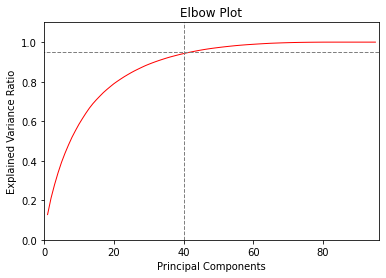

In [ ]:
from sklearn.decomposition import PCA

pca_pl = PCA(n_components=len(X_train.T))
pca_pl.fit(X_train)


plt.plot(np.arange(pca_pl.n_components_) + 1, np.cumsum(pca_pl.explained_variance_ratio_), linewidth=1, color='red')
plt.title('Elbow Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.hlines(0.95, -1, 100, linestyle="--", linewidth=1, color="grey")
plt.vlines(40, 0, 1.1, linestyle="--", linewidth=1, color="grey")
plt.xlim(0,96)
plt.ylim(0,1.1)
plt.show()


In [ ]:
pca = PCA(n_components=40)
pca.fit(X_train)
X_train_ = pca.transform(X_train)

In [ ]:
rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train_, y_train)
y_pred = rf_cf.predict_proba(X_train_)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf, X=X_train_, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
print(f"{auc_train}, {auc_cv}")

0.9999999997195568, 0.8752562692052871


In [ ]:
from xgboost import XGBClassifier

xgb_cf = XGBClassifier()
xgb_cf.fit(X_train_, y_train)
y_pred = xgb_cf.predict_proba(X_train_)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train_, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
print(f"{auc_train}, {auc_cv}")

0.9687131894105452, 0.9038857229115683


#### d. Treating Imbalances
Applying class weights

#### XGBoost

In [ ]:
from sklearn.utils import class_weight
classes_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))

weights = np.ones(y_train.shape[0], dtype='float')

for i, val in enumerate(y_train):
    weights[i] = classes_weights[val-1]

xgb_cf_w = XGBClassifier()
xgb_cf_w.fit(X_train, y_train, sample_weight=weights);

In [ ]:
y_pred = xgb_cf_w.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf_w, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
print(f"{auc_train}, {auc_cv}")

0.9594796427886951, 0.9256401412787248


In [ ]:
param_grid = [{
    "n_estimators":[100, 150, 200, 250, 300],
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.1, 0.5, 1]
}]

xgb_cf = XGBClassifier()
gs = GridSearchCV(xgb_cf, param_grid=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs=-1)
gs.fit(X_train, y_train, sample_weight=weights)#fit_params={'sample_weight': weights})

xgb_cf_w_opt = gs.best_estimator_

xgb_cf_w_opt.fit(X_train, y_train, sample_weight=weights)
y_pred = xgb_cf_w_opt.predict_proba(X_train)

auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf_w_opt, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [f"XGBoost - weights -optimized {gs.best_params_}", auc_train, auc_cv]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, xgb_cf_w_opt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     26698
           1       0.95      0.37      0.54      3356
           2       0.74      0.99      0.84     18904

    accuracy                           0.84     48958
   macro avg       0.88      0.72      0.75     48958
weighted avg       0.87      0.84      0.83     48958



#### Random Forest

In [ ]:
rf_cf_w = RandomForestClassifier(random_state=42)
rf_cf_w.fit(X_train, y_train, sample_weight=weights)
y_pred = rf_cf_w.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf_w, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
print(f"{auc_train}, {auc_cv}")

0.9999999997066454, 0.9022388708551381


In [ ]:
param_grid = [{
    "n_estimators":[300, 350, 400, 450, 500, 550],
    "max_depth": [16, 18, 20],
}]

rf_cf_w_opt = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rf_cf_w_opt, param_grid=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs=-1)
gs.fit(X_train, y_train, sample_weight=weights)#fit_params={'sample_weight': weights})

rf_cf_w_opt = gs.best_estimator_

rf_cf_w_opt.fit(X_train, y_train, sample_weight=weights)
y_pred = rf_cf_w_opt.predict_proba(X_train)

auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf_w_opt, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [f"Random Forest - weights -optimized {gs.best_params_}", auc_train, auc_cv]

### e. Different Preparation Pipelines

##### e1. With Age

In [ ]:
X_train_age = col_trans_w_age.fit_transform(X=df_train, y=y_train)

C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See h

In [ ]:
rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train_age, y_train)
y_pred = rf_cf.predict_proba(X_train_age)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf, X=X_train_age, y=y_train, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()
print(f'{auc_train}, {auc_cv}')

0.9999999943007573, 0.903358859215191


In [ ]:
param_grid = [{
    "n_estimators":[300, 350, 400, 450, 500, 550],
    "max_depth": [16, 18, 20],
}]

rf_cf_opt = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rf_cf_opt, param_grid=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs=-1)
gs.fit(X_train_age, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': [16, 18, 20],
                          'n_estimators': [300, 350, 400, 450, 500, 550]}],
             scoring='roc_auc_ovr')

In [ ]:
rf_cf_opt_age = gs.best_estimator_

rf_cf_opt_age.fit(X_train_age, y_train)
y_pred = rf_cf_opt_age.predict_proba(X_train_age)

auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf_opt_age, X=X_train_age, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [f"Random Forest - with Age - optimized - {gs.best_params_}", auc_train, auc_cv]

In [ ]:
xgb_cf = XGBClassifier()
xgb_cf.fit(X_train_age, y_train)
y_pred = xgb_cf.predict_proba(X_train_age)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train_age, y=y_train, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()
print(f'{auc_train}, {auc_cv}')

0.9665996207049984, 0.9261132067285827


In [ ]:
param_grid = [{
    "n_estimators":[100, 150, 200, 250, 300, 350],
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.1, 0.5, 1]
}]

xgb_cf = XGBClassifier()
gs = GridSearchCV(xgb_cf, param_grid=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs=-1)
gs.fit(X_train_age, y_train)
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}

In [ ]:
xgb_cf_opt_age = gs.best_estimator_

xgb_cf_opt_age.fit(X_train_age, y_train)
y_pred = xgb_cf_opt_age.predict_proba(X_train_age)

auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf_opt_age, X=X_train_age, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [f"XGBoost - with Age - optimized {gs.best_params_}", auc_train, auc_cv]

##### e2. With Label Encoding

In [ ]:
X_train_lbl = col_trans_lbl.fit_transform(X=df_train, y=y_train)

C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See h

In [ ]:
rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train_lbl, y_train)
y_pred = rf_cf.predict_proba(X_train_lbl)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf, X=X_train_lbl, y=y_train, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()
print(f'{auc_train}, {auc_cv}')

0.9999999985977842, 0.9036087690141258


In [ ]:
xgb_cf = XGBClassifier()
xgb_cf.fit(X_train_lbl, y_train)
y_pred = xgb_cf.predict_proba(X_train_lbl)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train_lbl, y=y_train, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()
print(f'{auc_train}, {auc_cv}')

0.9654367675010289, 0.9249200755711685


##### e3. Only important features

In [ ]:
X_train_lbl_reduced = col_trans_lbl_reduced.fit_transform(X=df_train, y=y_train)

C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See h

In [ ]:
rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train_lbl_reduced, y_train)
y_pred = rf_cf.predict_proba(X_train_lbl_reduced)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf, X=X_train_lbl_reduced, y=y_train, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()
print(f'{auc_train}, {auc_cv}')

0.9942672103411531, 0.8936788650084717


In [ ]:
xgb_cf = XGBClassifier()
xgb_cf.fit(X_train_lbl_reduced, y_train)
y_pred = xgb_cf.predict_proba(X_train_lbl_reduced)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train_lbl_reduced, y=y_train, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()
print(f'{auc_train}, {auc_cv}')

0.9570157063169051, 0.9226011300567969


In [ ]:
df_tuned.to_csv("pm3_tuned.csv")

## Evaluation

With unseen test data (out-of-sample validation)

In [ ]:
df_pump_test = pd.read_csv("pump_test.csv")

df_test = df_pump_test.copy()

df_test["t_functional"] = df_test["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_test["t_needs_rep"] = df_test["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

df_test = df_test.drop(df_test[df_test.longitude == 0].index)

df_test["amount_per_capita"] = df_test.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)
df_test["age"]=df_test['date_recorded'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))-df_train["construction_year"].apply(lambda x: datetime.datetime.strptime(str(x),'%Y') if x!=0 else datetime.datetime.now())
df_test["age"].loc[df_test["construction_year"]!=0]=df_test["age"].loc[df_test["construction_year"]!=0].apply(lambda x: x.days)
df_test["age"].loc[df_test["construction_year"]==0]=np.nan

df_test["district_code"] = df_test["district_code"].astype("category")
df_test["region_code"] = df_test["region_code"].astype("category")

y_test = df_test.loc[:,'status_group']
y_test = le.transform(y_test)

y_test_f = df_test["t_functional"]
y_test_r = df_test["t_needs_rep"]

NameError: name 'pd' is not defined

In [ ]:
X_test = col_trans.transform(X=df_test)
X_test_age = col_trans_w_age.transform(X=df_test)

KeyError: "None of [Index(['age'], dtype='object')] are in the [columns]"

In [ ]:
auc_test_rf = roc_auc_score(y_test, rf_cf_opt.predict_proba(X_test), multi_class='ovr')
auc_test_xgb = roc_auc_score(y_test, xgb_cf_opt.predict_proba(X_test), multi_class='ovr')

In [ ]:
auc_test_rf_w = roc_auc_score(y_test, rf_cf_w_opt.predict_proba(X_test), multi_class='ovr')
auc_test_xgb_w = roc_auc_score(y_test, xgb_cf_w_opt.predict_proba(X_test), multi_class='ovr')

In [ ]:
auc_test_rf_age = roc_auc_score(y_test, rf_cf_opt_age.predict_proba(X_test_age), multi_class='ovr')
auc_test_xgb_age = roc_auc_score(y_test, xgb_cf_opt_age.predict_proba(X_test_age), multi_class='ovr')

In [ ]:
df_tuned["AUC Test"] = [auc_test_rf, auc_test_xgb, auc_test_xgb_w, auc_test_rf_w]
df_tuned.to_csv("pm3_tuned.csv")
df_tuned

,Model,AUC Train,AUC CV,AUC Test
0,"RandomForestClassifier(max_depth=18, n_estimat...",0.992420,0.916088,0.899027
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.978028,0.926525,0.859736
2,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.978048,0.926460,0.863119
3,"RandomForestClassifier(max_depth=20, n_estimat...",0.993145,0.915264,0.891627


In [ ]:
from yellowbrick.classifier import ROCAUC

def plot_ROC(model, X_train, y_train, X_test, y_test):

    vis = ROCAUC(model, encoder={0: 'functional', 1: ' func_needs_rep', 2: 'non_functional'})
                                                                         
    vis.fit(X_train, y_train)
    vis.score(X_test, y_test)
    vis.show()
    
    return vis

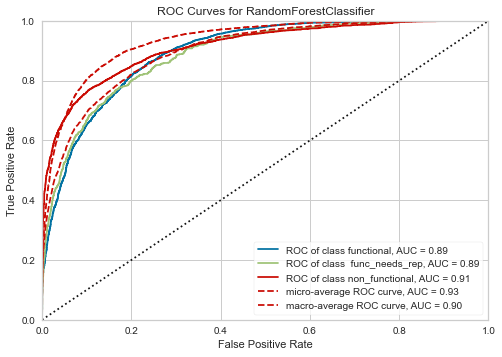

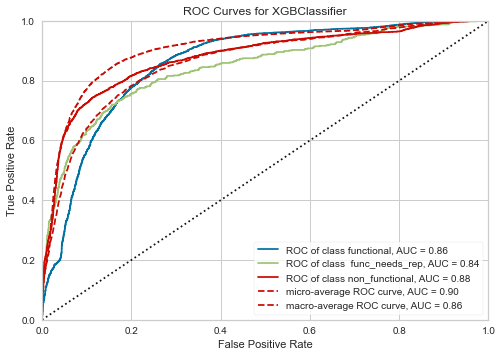

In [ ]:
plot_ROC(rf_cf_opt, X_train, y_train, X_test, y_test)
plot_ROC(xgb_cf_opt, X_train, y_train, X_test, y_test);

C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


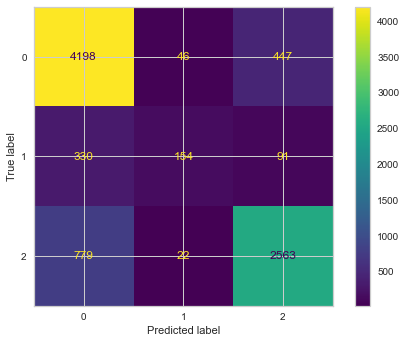

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rf_cf_opt, X_test, y_test);

In [ ]:
print(classification_report(y_test, rf_cf_opt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      4691
           1       0.69      0.27      0.39       575
           2       0.83      0.76      0.79      3364

    accuracy                           0.80      8630
   macro avg       0.77      0.64      0.67      8630
weighted avg       0.80      0.80      0.79      8630



C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


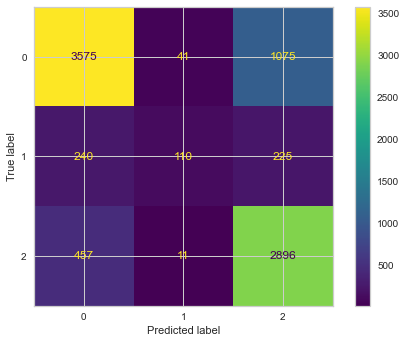

In [ ]:
plot_confusion_matrix(rf_cf_w_opt, X_test, y_test);

In [ ]:
# plot_confusion_matrix(xgb_cf_opt, X_test, y_test)

In [ ]:
df_pump_test["status_group"].value_counts()

functional                 4823
non functional             3447
functional needs repair     640
Name: status_group, dtype: int64